# Risk Management GWP 2


In [10]:
!pip install hmms --quiet
!pip install pgmpy --quiet
!pip install fredapi --quiet

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hmms
import networkx as nx


from pgmpy.estimators import BicScore, K2Score
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BayesianEstimator
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import Colormap, ListedColormap, BoundaryNorm

from fredapi import Fred
api_key = "a98f1a6c0024e4c1e88b4aeac03bd09f"
fred = Fred(api_key)


start_date = "1990-01-01"
end_date = "2024-01-01"

In [12]:
crude_oil_price = pd.DataFrame(fred.get_series('WTISPLC'), columns=['WTISPLC'])
crude_oil_price = crude_oil_price[(crude_oil_price.index >= start_date) & (crude_oil_price.index <= end_date)]

## Step 1 ##

### Forward algorithm
Input:
- O: Partially observed sequence of length T
- λ: Model parameters (transition probabilities, emission probabilities, initial state distribution)

Output:
- α: Forward variables

Procedure ForwardAlgorithm(O, λ):
    N <- number of hidden states
    T <- length of the observed sequence O

    Initialize α matrix of size (T, N) with zeros

    // Base case: Compute α1(i)
    for i = 1 to N do:
        α[1, i] <- λ.pi[i] * λ.b[i, O[1]]

    // General case: Compute αt+1(i)
    for t = 1 to T-1 do:
        for i = 1 to N do:
            sum <- 0
            for j = 1 to N do:
                sum <- sum + α[t, j] * λ.a[j, i]
            α[t+1, i] <- λ.b[i, O[t+1]] * sum

    return α

In [13]:
def forward_algorithm(O, pi, A, B):
    N = len(pi)  # Number of hidden states
    T = len(O)  # Length of the observed sequence

    alpha = [[0] * N for _ in range(T)]  # Initialize alpha matrix

    # Base case: Compute alpha for the first time step
    for i in range(N):
        alpha[0][i] = pi[i] * B[i][O[0]]

    # General case: Compute alpha for subsequent time steps
    for t in range(1, T):
        for i in range(N):
            sum_ = 0
            for j in range(N):
                sum_ += alpha[t-1][j] * A[j][i]
            alpha[t][i] = B[i][O[t]] * sum_

    return alpha

observed_sequence = [0, 1, 0]
initial_state_distribution = [0.6, 0.4]
transition_matrix = [[0.7, 0.3], [0.4, 0.6]]
emission_matrix = [[0.1, 0.9], [0.5, 0.5]]

alpha_matrix = forward_algorithm(
    observed_sequence, initial_state_distribution, transition_matrix, emission_matrix
)

# Print the computed alpha matrix
for row in alpha_matrix:
    print(row)

[0.06, 0.2]
[0.10980000000000001, 0.06899999999999999]
[0.010446, 0.037169999999999995]


### Backward algorithm

Input:
- O: Partially observed sequence of length T
- λ: Model parameters (transition probabilities, emission probabilities, initial state distribution)

Output:
- β: Backward variables

Procedure BackwardAlgorithm(O, λ):
    N <- number of hidden states
    T <- length of the observed sequence O

    Initialize β matrix of size (T, N) with zeros

    // Base case: Set βT(i) = 1 for all i
    for i = 1 to N do:
        β[T, i] <- 1

    // General case: Compute βt(i)
    for t = T-1 downto 1 do:
        for i = 1 to N do:
            sum <- 0
            for j = 1 to N do:
                sum <- sum + λ.a[i, j] * λ.b[j, O[t+1]] * β[t+1, j]
            β[t, i] <- sum

    return β

In [14]:
def backward_algorithm(O, pi, A, B):
    N = len(pi)  # Number of hidden states
    T = len(O)  # Length of the observed sequence

    beta = [[0] * N for _ in range(T)]  # Initialize beta matrix

    # Base case: Set beta for the last time step to 1 for all hidden states
    for i in range(N):
        beta[T-1][i] = 1

    # General case: Compute beta for previous time steps
    for t in range(T-2, -1, -1):
        for i in range(N):
            sum_ = 0
            for j in range(N):
                sum_ += A[i][j] * B[j][O[t+1]] * beta[t+1][j]
            beta[t][i] = sum_

    return beta

observed_sequence = [0, 1, 0]
initial_state_distribution = [0.6, 0.4]
transition_matrix = [[0.7, 0.3], [0.4, 0.6]]
emission_matrix = [[0.1, 0.9], [0.5, 0.5]]

beta_matrix = backward_algorithm(
    observed_sequence, initial_state_distribution, transition_matrix, emission_matrix
)

# Print the computed beta matrix
for row in beta_matrix:
    print(row)

[0.18959999999999996, 0.1812]
[0.21999999999999997, 0.33999999999999997]
[1, 1]


### Backward Viterbi Algorithm

    Function to perform the backward Viterbi algorithm
    function backward_viterbi(obs, states, start_prob, trans_prob, emit_prob):
    T = length of obs
    N = length of states

    Create a 2D array beta with dimensions T x N

    for each state i from 0 to N-1:
        Set beta[T-1][i] to 1

    for each time step t from T-2 down to 0:
        for each state i from 0 to N-1:
            sum_beta = 0
            for each state j from 0 to N-1:
                sum_beta = sum_beta + beta[t+1][j] * trans_prob[i][j] * emit_prob[j][obs[t+1]]
            Set beta[t][i] to sum_beta

    prob_obs_given_model = 0
    for each state i from 0 to N-1:
        prob_obs_given_model = prob_obs_given_model + start_prob[i] * emit_prob[i][obs[0]] * beta[0][i]

    return beta, prob_obs_given_model

    obs = [0, 1, 0]
    states = [0, 1]
    start_prob = [0.5, 0.5]
    trans_prob = [[0.7, 0.3], [0.4, 0.6]]
    emit_prob = [[0.5, 0.5], [0.8, 0.2]]

    beta_matrix, prob_obs_given_model = backward_viterbi(obs, states, start_prob, trans_prob, emit_prob)

    Print "Backward Matrix:"
    for each row in beta_matrix:
    Print row
    Print "Probability of observing the sequence given the model:", prob_obs_given_model

In [15]:
# Backward Viterbi Algorithm

# Function to perform the backward Viterbi algorithm
def backward_viterbi(obs, states, start_prob, trans_prob, emit_prob):
    # Number of observations
    T = len(obs)
    # Number of states
    N = len(states)

    # Initialize the backward matrix
    beta = [[0] * N for _ in range(T)]

    # Initialize the last column of the backward matrix to 1
    for i in range(N):
        beta[T-1][i] = 1

    # Backward pass
    for t in range(T-2, -1, -1):
        for i in range(N):
            beta[t][i] = sum(beta[t+1][j] * trans_prob[i][j] * emit_prob[j][obs[t+1]] for j in range(N))

    # Calculate the probability of observing the sequence given the model
    prob_obs_given_model = sum(start_prob[i] * emit_prob[i][obs[0]] * beta[0][i] for i in range(N))

    return beta, prob_obs_given_model

# Toy example
obs = [0, 1, 0]  # Observations
states = [0, 1]  # States: 0 for "H" (heads), 1 for "T" (tails)
start_prob = [0.5, 0.5]  # Initial probabilities
trans_prob = [[0.7, 0.3], [0.4, 0.6]]  # Transition probabilities
emit_prob = [[0.5, 0.5], [0.8, 0.2]]  # Emission probabilities

beta_matrix, prob_obs_given_model = backward_viterbi(obs, states, start_prob, trans_prob, emit_prob)

print("Backward Matrix:")
for row in beta_matrix:
    print(row)
print("Probability of observing the sequence given the model:", prob_obs_given_model)

Backward Matrix:
[0.2473, 0.1996]
[0.59, 0.6799999999999999]
[1, 1]
Probability of observing the sequence given the model: 0.141665


### Baum Welch Algorithm

In [16]:
def baum_welch(V, a, b, initial_distribution, n_iter=100):
    M = a.shape[0]
    T = len(V)

    for n in range(n_iter):
        alpha = forward_algorithm(V, a, b, initial_distribution)
        beta = backward_algorithm(V, a, b)

        xi = np.zeros((M, M, T - 1))
        for t in range(T - 1):
            denominator = np.dot(np.dot(alpha[t, :].T, a) * b[:, V[t + 1]].T, beta[t + 1, :])
            for i in range(M):
                numerator = alpha[t, i] * a[i, :] * b[:, V[t + 1]].T * beta[t + 1, :].T
                xi[i, :, t] = numerator / denominator

        gamma = np.sum(xi, axis=1)
        a = np.sum(xi, 2) / np.sum(gamma, axis=1).reshape((-1, 1))

        # Add additional T'th element in gamma
        gamma = np.hstack((gamma, np.sum(xi[:, :, T - 2], axis=0).reshape((-1, 1))))

        K = b.shape[1]
        denominator = np.sum(gamma, axis=1)
        for l in range(K):
            b[:, l] = np.sum(gamma[:, V == l], axis=1)

        b = np.divide(b, denominator.reshape((-1, 1)))

    return (a, b)

## Step 2 ##

In [17]:

crude_oil_price['Price Change Percentage'] = crude_oil_price['WTISPLC'].pct_change()
crude_oil_price['Price Change Indicator'] = crude_oil_price['WTISPLC'].pct_change()[1:].gt(0).astype(int)

<ipython-input-17-c94223d03fc8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crude_oil_price['Price Change Percentage'] = crude_oil_price['WTISPLC'].pct_change()
<ipython-input-17-c94223d03fc8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crude_oil_price['Price Change Indicator'] = crude_oil_price['WTISPLC'].pct_change()[1:].gt(0).astype(int)


We consider three hidden states in the HMMS i.e. Bear, Bull and Stagnant Regime which finally percolates into the 2 different price directions for the crude oil price which is either positive or negative

We have created a HMM of 3 states and 2 observations to replicate for the crude oild price change. Further, it should be noted that the discrete time hidden markov model takes in ndarray which can have a maximum length of 32. Thus, we have split the array of price change indicator in arrays of size 32 or less using the array_split functions

In [18]:
dthmm_rand = hmms.DtHMM.random(3,2)
price_change_indicator = crude_oil_price['Price Change Indicator'].values[1:].astype(np.int64)
price_change_indicator = np.array_split(price_change_indicator,13)
# price_change_indicator

In [19]:
# We apply baum welch algorithm to optimize the model to replicate the observations as provided:
dthmm_rand.baum_welch(price_change_indicator, iterations=100);

iteration  1 / 100
iteration  2 / 100
iteration  3 / 100
iteration  4 / 100
iteration  5 / 100
iteration  6 / 100
iteration  7 / 100
iteration  8 / 100
iteration  9 / 100
iteration  10 / 100
iteration  11 / 100
iteration  12 / 100
iteration  13 / 100
iteration  14 / 100
iteration  15 / 100
iteration  16 / 100
iteration  17 / 100
iteration  18 / 100
iteration  19 / 100
iteration  20 / 100
iteration  21 / 100
iteration  22 / 100
iteration  23 / 100
iteration  24 / 100
iteration  25 / 100
iteration  26 / 100
iteration  27 / 100
iteration  28 / 100
iteration  29 / 100
iteration  30 / 100
iteration  31 / 100
iteration  32 / 100
iteration  33 / 100
iteration  34 / 100
iteration  35 / 100
iteration  36 / 100
iteration  37 / 100
iteration  38 / 100
iteration  39 / 100
iteration  40 / 100
iteration  41 / 100
iteration  42 / 100
iteration  43 / 100
iteration  44 / 100
iteration  45 / 100
iteration  46 / 100
iteration  47 / 100
iteration  48 / 100
iteration  49 / 100
iteration  50 / 100
iteration

In [20]:
# Generating the paramters of the Discrete Time Hidden Markov Model
hmms.print_parameters(dthmm_rand);

Initial probabilities (π) :


,0
0,0.034929
1,0.958689
2,0.006382


Transition probabilities matrix (A):


,0,1,2
0,0.195836,0.255375,0.548789
1,0.405824,0.450843,0.143333
2,0.254181,0.260194,0.485625


Emission probabilities matrix (B):


,0,1
0,0.513356,0.486644
1,0.661724,0.338276
2,0.143440,0.856560


Reference: https://medium.com/@zhe.feng0018/coding-viterbi-algorithm-for-hmm-from-scratch-ca59c9203964

In [21]:
def viterbi(y, A, B, pi):
    """
        viterbi algorithm
        :param y: observation sequence
        :param A: the transition matrix
        :param B: the emission matrix
        :param pi: the initial probability distribution
    """
    N = B.shape[0]
    x_seq = np.zeros([N, 0])
    V = B[:, y[0]] * pi

    # forward to compute the optimal value function V
    for y_ in y[1:]:
        _V = np.tile(B[:, y_], reps=[N, 1]).T * A.T * np.tile(V, reps=[N, 1])
        x_ind = np.argmax(_V, axis=1)
        x_seq = np.hstack([x_seq, np.c_[x_ind]])
        V = _V[np.arange(N), x_ind]
    x_T = np.argmax(V)

    # backward to fetch optimal sequence
    x_seq_opt, i = np.zeros(x_seq.shape[1]+1), x_seq.shape[1]-1
    prev_ind = x_T
    while i >= 0:
        x_seq_opt[i] = prev_ind
        i -= 1
        prev_ind = x_seq[int(prev_ind), i]
    return x_seq_opt

In [22]:
state_sequence = viterbi(np.concatenate(price_change_indicator), dthmm_rand.params[0], dthmm_rand.params[1], dthmm_rand.params[2])

In [23]:
crude_oil_price = crude_oil_price.iloc[1:]
crude_oil_price['State Sequence'] = state_sequence

<ipython-input-23-d139c3cec9ec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crude_oil_price['State Sequence'] = state_sequence


In [24]:
#backward_viterbi(np.concatenate(price_change_indicator), [0,1,2], dthmm_rand.params[2], dthmm_rand.params[0], dthmm_rand.params[1])
pd.pivot_table(crude_oil_price, values = 'Price Change Percentage', index = 'State Sequence')

,Price Change Percentage
State Sequence,
0.0,-0.064138
1.0,-0.079920
2.0,0.066460


From the analysis of the return we come to know that the Bear Regime corresponds to State Sequence 0, the Stable Regime corresponds to State sequence 1 and the bull Regime corresponds to State Sequence 2

The chart below shows the examples of Bear, Bull and Stagnant Regimes for crude oil prices

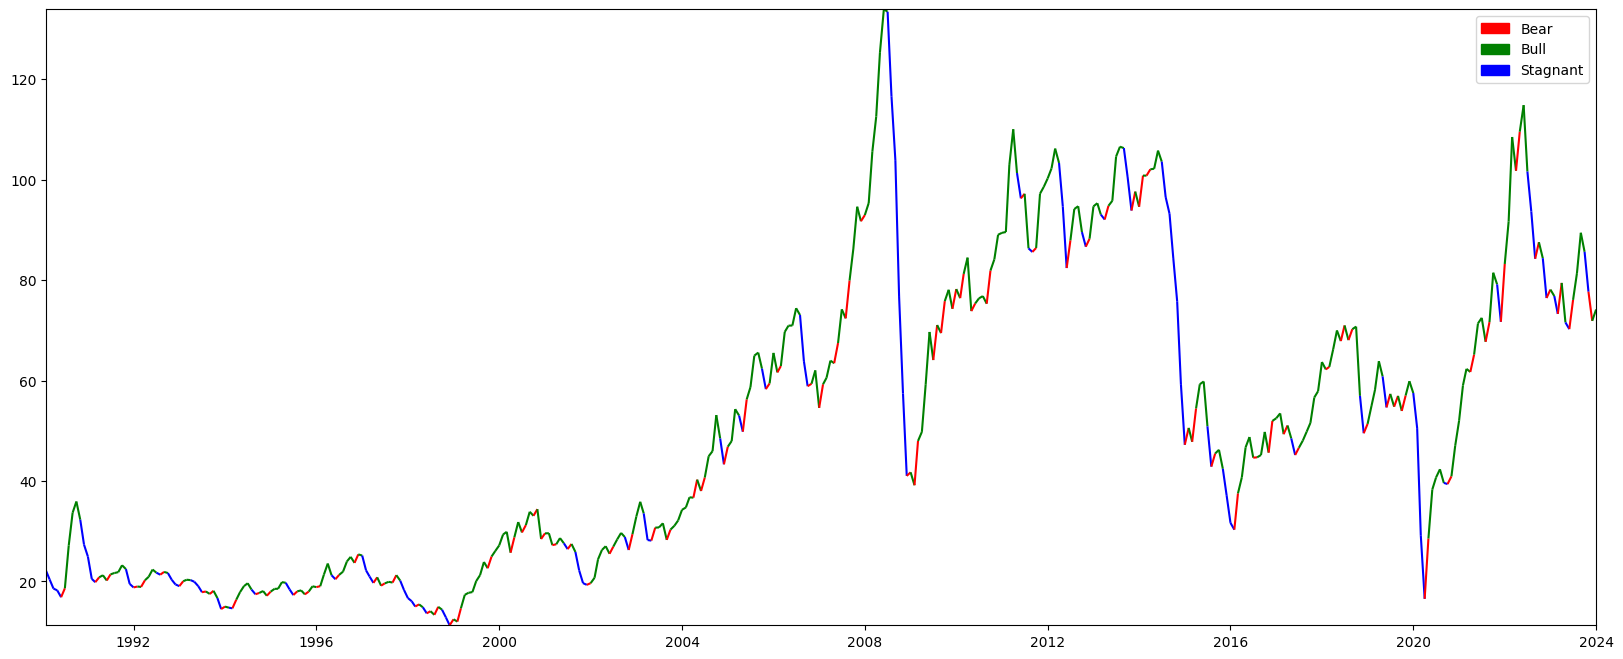

In [25]:
fig, ax1 = plt.subplots(figsize=(20,8));
ax1.plot(crude_oil_price['WTISPLC'], color='w', alpha=0.5);

# Make 0 (Stagnant) - red, 1 (Bear) - blue, 2 (Bull) - green

cmap   = ListedColormap(['r','b','g'],'indexed');
norm   = BoundaryNorm(range(3 + 1), cmap.N);
inxval = mdates.date2num(crude_oil_price['WTISPLC'].index.to_pydatetime());
points = np.array([inxval, crude_oil_price['WTISPLC']]).T.reshape(-1, 1, 2);
segments = np.concatenate([points[:-1], points[1:]], axis=1);

lc = LineCollection(segments, cmap=cmap, norm=norm);
lc.set_array(crude_oil_price['State Sequence']);
plt.gca().add_collection(lc);
plt.xlim(crude_oil_price['WTISPLC'].index.min(), crude_oil_price['WTISPLC'].index.max());
plt.ylim(crude_oil_price['WTISPLC'].min(), crude_oil_price['WTISPLC'].max());

r_patch = mpatches.Patch(color='red', label='Bear');
g_patch = mpatches.Patch(color='green', label='Bull');
b_patch = mpatches.Patch(color='blue', label='Stagnant');

plt.legend(handles=[r_patch, g_patch, b_patch]);

plt.show();

## Step 9

In [26]:


np.random.seed(42)
data = pd.DataFrame(np.random.randint(0, 3, size=(1500, 8)),
                        columns=list('ABCDEFGH'));
data['A'] += data['B'] + data['C'];
data['H'] = data['G'] - data['A'];

# learn the network structure
hc = HillClimbSearch(data);
model = hc.estimate(scoring_method=BicScore(data));

  0%|          | 0/1000000 [00:00<?, ?it/s]

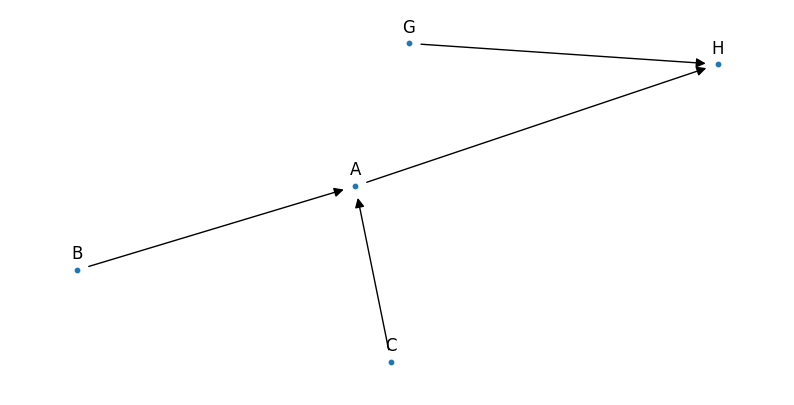

In [27]:


G = nx.MultiDiGraph()
G.add_edges_from(model.edges())

# Define the names of the vertices
vertex_names = {'A': 'A', 'B': 'B', 'C': 'C', 'H': 'H', 'G': 'G'}

pos = nx.spring_layout(G)
label_pos = {k: (v[0], v[1] + 0.06) for k, v in pos.items()}

plt.figure(figsize=(10, 5))

# Draw nodes with vertex names as labels
nx.draw_networkx_nodes(G, pos, node_size=10)
nx.draw_networkx_labels(G, label_pos, labels=vertex_names)

# Draw edges
nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=14, arrowstyle='-|>')

plt.axis('off')
plt.show()